# 0. Import libraries

In [1]:
import os
import re
import sys
import time
import pickle
import importlib
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import networkx as nx
import osmnx as ox

# Specify the directory containing the .py modules
module_dir = "../modules"

# Add the directory to the Python path
sys.path.append(os.path.abspath(module_dir))

In [2]:
from map_resources_v2 import MapResources

# 1. Extract Graph Networks
* * *
We mainly use the `osmnx` Python library to query and locally save the graph networks of roads (and walkable paths) that will be used to build our network of schools. For roads or paths that `osmnx` seem to not cover, we use <a href="https://overpass-turbo.eu/">overpass-turbo</a>. The query used in overpass is included at the end of this section.

Based on experience, only specialized and high-power machines are able to query the graph network of the entire Philippines in one call. Given the limitations of the machine used in this project, we broke our `osmnx` graph network queries by region. Note that despite breaking our queries by region, we highly advise to separate the Python code for querying in separate cells - as in this section.

## 1.1. Load PH Shapefiles
The shapefiles of regions used as input to `osmnx` when querying graph networks were sourced from this <a href='https://github.com/altcoder/philippines-psgc-shapefiles'>github repo</a>.

We load the Philippine shapefiles dataset that follows the PSA PSGC that has been preprocessed and rearranged by `map_resources` module.

In [3]:
%%time
# We initialize the class that also preloads and reorganizes PH shapefiles
mr = MapResources(preloaded=True)

# Locations/geographies that do not have geometries were dropped
gpd_gadm = mr.gadm.copy()

print(gpd_gadm.shape)
print(gpd_gadm.crs)        # The crs of our shapefiles should be 4326
display(gpd_gadm.head(2))

(42048, 14)
EPSG:4326


,adm1_psgc,adm1_psgc_name,adm2_psgc,adm2_psgc_name,adm3_psgc,adm3_psgc_name,adm4_psgc,adm4_psgc_name,city_class,geo_level,inc_class,shape_sqkm,urb_rur,geometry
0,0100000000,Region I (Ilocos Region),0102800000,Ilocos Norte,0102801000,Adams,0102801001,Adams,None,Bgy,None,111.143026,None,"POLYGON ((120.92068 18.51462, 120.94626 18.511..."
1,0100000000,Region I (Ilocos Region),0102800000,Ilocos Norte,0102802000,Bacarra,0102802001,Bani,None,Bgy,None,1.759757,None,"POLYGON ((120.61278 18.27590, 120.61282 18.275..."


CPU times: user 346 ms, sys: 509 ms, total: 855 ms
Wall time: 3.9 s


We display the 17 PH regions that we will use to query and save graph networks from osmnx.

In [4]:
unique_regions = (
    gpd_gadm.groupby(['adm1_psgc','adm1_psgc_name'])['adm2_psgc']
    .size()
    .index.tolist()
)
display(unique_regions)

[('0100000000', 'Region I (Ilocos Region)'),
 ('0200000000', 'Region II (Cagayan Valley)'),
 ('0300000000', 'Region III (Central Luzon)'),
 ('0400000000', 'Region IV-A (CALABARZON)'),
 ('0500000000', 'Region V (Bicol Region)'),
 ('0600000000', 'Region VI (Western Visayas)'),
 ('0700000000', 'Region VII (Central Visayas)'),
 ('0800000000', 'Region VIII (Eastern Visayas)'),
 ('0900000000', 'Region IX (Zamboanga Peninsula)'),
 ('1000000000', 'Region X (Northern Mindanao)'),
 ('1100000000', 'Region XI (Davao Region)'),
 ('1200000000', 'Region XII (SOCCSKSARGEN)'),
 ('1300000000', 'National Capital Region (NCR)'),
 ('1400000000', 'Cordillera Administrative Region (CAR)'),
 ('1600000000', 'Region XIII (Caraga)'),
 ('1700000000', 'MIMAROPA Region'),
 ('1900000000', 'Bangsamoro Autonomous Region In Muslim Mindanao (BARMM)')]

## 1.2. Query Graph Networks

### Helper functions
We write functions that will facilitate our querying of the graph networks of our regions.

In [5]:
def save_pickle(sv_path, G):
    """
    Saves a Python object (e.g., a graph network) to a file using pickle.

    Args:
        sv_path (str): The full path to the file where the object will be saved.
                       This should include the filename and extension (e.g., 'data/graph.pkl').
        G (object): The Python object to be serialized and saved.

    Returns:
        bool: True if the object was successfully saved.
    """
    with open(sv_path, 'wb') as file:
        pickle.dump(G, file)
    return True


def load_pickle(fpath):
    """
    Loads a Python object from a pickle file.

    Args:
        fpath (str): The full path to the pickle file to be loaded.

    Returns:
        object: The deserialized Python object from the file.
    """
    with open(fpath, 'rb') as file:
        graph_network = pickle.load(file)
    return graph_network


def save_osmnx_network(unique_regions, ix, gpd_gadm, dir_savepath, depth=3):
    """
    Extracts a road network using OSMnx for a specified administrative region
    and its adjacent geographies up to a certain depth, then saves the network
    to a pickle file.

    This function iterates through administrative regions, identifies the target
    region and its neighbors, retrieves the corresponding geographic shapes,
    downloads the OpenStreetMap network data for that area, and saves the
    resulting graph.

    Args:
        unique_regions (list or tuple): A list or tuple containing unique administrative
                                   region identifiers. Each element is expected to
                                   be a tuple or list like (PSGC_code, English_name).
        ix (int): The index of the target administrative region within `unique_regions`
                  to be processed in the current iteration.
        gpd_gadm (geopandas.GeoDataFrame): A GeoDataFrame containing administrative
                                            boundary data, likely from GADM,
                                            used to retrieve geographical shapes
                                            and adjacency information.
        dir_savepath (str): The directory path where the extracted graph network
                            (as a pickle file) will be saved. The directory will
                            be created if it does not exist.
        depth (int, optional): The maximum depth to search for adjacent geographies.
                               A depth of 0 means only the target region, 1 means
                               target + direct neighbors, and so on. Defaults to 3.

    Returns:
        None: The function saves the graph network to a file and prints progress,
              but does not return any value.

    Raises:
        Exception: Catches and prints general exceptions that might occur during
                   network extraction or saving.
    """
    iter_stime = time.time()
    adm1_psgc, adm1_en = unique_regions[ix]
    
    print(f"At region: {adm1_en}")
    max_depth = depth

    try:
        print(f"Getting target and adjacent geographies with depth {max_depth}")
        geo_results = mr.get_adjacent_geographies(
            gpd_gadm=gpd_gadm,
            target_psgc=adm1_psgc,
            max_depth=max_depth
        )

        shape_osmnx = geo_results['search_shape_complete']
        graph_network = ox.graph_from_polygon(
            shape_osmnx, network_type='walk', truncate_by_edge=True, retain_all=True,
        )

        print(f"Saving extracted graph network.")
        os.makedirs(dir_savepath, exist_ok=True) # Ensure save directory exists

        sv_label = f'{adm1_en}.pkl'
        sv_path = os.path.join(dir_savepath, sv_label)
        save_pickle(sv_path, graph_network)

        iter_etime = time.time() - iter_stime # Corrected calculation for elapsed time
        print(f"Time elapsed for iteration: {iter_etime:.2f} seconds")

    except Exception as e:
        print(f"An error occurred for region {adm1_en}: {e}")

### Query by Region
We use our defined functions above to query and save the graph networks of our regions in our local machine at `../datasets/networks/regional_drive_graphs`.

We will only run and show the output of the function `save_osmnx_network` for Region I (Ilocos Region) only. This is to demonstrate the output of the aforementioned function and the possible runtime of querying graph networks from osmnx.

<strong>Important note</strong>: the regional graph networks should exist in our local machine in `../datasets/networks/regional_drive_graphs` in order for us to progress with the project. Therefore, if the 17 regional graph networks does not yet exist in your local machine, make sure that you run the code cells in the `Query Other Regions` section below.

In [14]:
path = '../datasets/networks/regional_drive_graphs'

save_osmnx_network(
    unique_regions,
    ix=0,              # query graph network of Region I (Ilocos Region)
    gpd_gadm=gpd_gadm,
    dir_savepath=path,
    depth=3
)

At region: Region I (Ilocos Region)
Getting target and adjacent geographies with depth 3
Finding adjacent geographies for PSGC 0100000000 with max_depth=3
Detected administrative level: region
Finding adjacent areas at depth 1...
Found 154 adjacent areas at depth 1
Finding adjacent areas at depth 2...
Found 231 adjacent areas at depth 2
Finding adjacent areas at depth 3...
Found 270 adjacent areas at depth 3
Geography processing completed in 4.92 seconds


/opt/conda/lib/python3.11/site-packages/osmnx/_overpass.py:254: UserWarning: This area is 16 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


Saving extracted graph network.
Time elapsed for iteration: 227.48 seconds


We plot our graph network to inspect if we extracted from the correct region. 

In [ ]:
# %%time
# fpath = '../datasets/networks/regional_drive_graphs/Region I (Ilocos Region).pkl'
# g_net = load_pickle(fpath)

# # For sanity, we plot our geographies, schools, and subgraph road network
# fig, ax = ox.plot_graph(
#     g_net, figsize=(10,10),
#     node_size=.5, edge_linewidth=.5,
#     bgcolor='none', show=False, close=False,
#     node_zorder=4, edge_color='black',
# )

# plt.savefig(
#     '../output/2.0-region1-graph-network.jpg',
#     dpi=100, transparent=False, bbox_inches='tight'
# )

# plt.show()
# plt.close() # Run time was: 17.7 seconds

To minimize the file size of this notebook, we saved the output of the cell above as an image and dispaly it in this markdown cell.

<img src="../output/2.0-region1-graph-network.jpg" height="0" weight="0">

### Query Other Regions

In [ ]:
# save_osmnx_network(
#     unique_regions,
#     ix=1,              # query graph network of Region II (Cagayan Valley)
#     gpd_gadm=gpd_gadm,
#     dir_savepath=path,
#     depth=3
# )

In [ ]:
# save_osmnx_network(
#     unique_regions,
#     ix=2,              # query graph network of Region III (Central Luzon)
#     gpd_gadm=gpd_gadm,
#     dir_savepath=path,
#     depth=3
# )

In [ ]:
# save_osmnx_network(
#     unique_regions,
#     ix=3,              # query graph network of Region IV-A (CALABARZON)
#     gpd_gadm=gpd_gadm,
#     dir_savepath=path,
#     depth=3
# )

In [ ]:
# save_osmnx_network(
#     unique_regions,
#     ix=4,              # query graph network of Region V (Bicol Region)
#     gpd_gadm=gpd_gadm,
#     dir_savepath=path,
#     depth=3
# )

In [ ]:
# save_osmnx_network(
#     unique_regions,
#     ix=5,              # query graph network of Region VI (Western Visayas)
#     gpd_gadm=gpd_gadm,
#     dir_savepath=path,
#     depth=3
# )

In [ ]:
# save_osmnx_network(
#     unique_regions,
#     ix=6,              # query graph network of Region VII (Central Visayas)
#     gpd_gadm=gpd_gadm,
#     dir_savepath=path,
#     depth=3
# )

In [ ]:
# save_osmnx_network(
#     unique_regions,
#     ix=7,              # query graph network of Region VIII (Eastern Visayas)
#     gpd_gadm=gpd_gadm,
#     dir_savepath=path,
#     depth=3
# )

In [ ]:
# save_osmnx_network(
#     unique_regions,
#     ix=8,              # query graph network of Region IX (Zamboanga Peninsula)
#     gpd_gadm=gpd_gadm,
#     dir_savepath=path,
#     depth=3
# )

In [ ]:
# save_osmnx_network(
#     unique_regions,
#     ix=9,              # query graph network of Region X (Northern Mindanao)
#     gpd_gadm=gpd_gadm,
#     dir_savepath=path,
#     depth=3
# )

In [ ]:
# save_osmnx_network(
#     unique_regions,
#     ix=10,              # query graph network of Region XI (Davao Region)
#     gpd_gadm=gpd_gadm,
#     dir_savepath=path,
#     depth=3
# )

In [ ]:
# save_osmnx_network(
#     unique_regions,
#     ix=11,              # query graph network of Region XII (SOCCSKSARGEN)
#     gpd_gadm=gpd_gadm,
#     dir_savepath=path,
#     depth=3
# )

In [ ]:
# save_osmnx_network(
#     unique_regions,
#     ix=12,              # query graph network of National Capital Region (NCR)')
#     gpd_gadm=gpd_gadm,
#     dir_savepath=path,
#     depth=3
# )

In [ ]:
# # query graph network of Cordillera Administrative Region (CAR)
# save_osmnx_network(
#     unique_regions,
#     ix=13,
#     gpd_gadm=gpd_gadm,
#     dir_savepath=path,
#     depth=3
# )

In [ ]:
# save_osmnx_network(
#     unique_regions,
#     ix=14,              # query graph network of Region XIII (Caraga)
#     gpd_gadm=gpd_gadm,
#     dir_savepath=path,
#     depth=3
# )

In [6]:
path = '../datasets/networks/regional_drive_graphs'

save_osmnx_network(
    unique_regions,
    ix=15,              # query graph network of MIMAROPA Region
    gpd_gadm=gpd_gadm,
    dir_savepath=path,
    depth=3
)

At region: MIMAROPA Region
Getting target and adjacent geographies with depth 3
Finding adjacent geographies for PSGC 1700000000 with max_depth=3
Detected administrative level: region
Finding adjacent areas at depth 1...
No more adjacent areas found at depth 1
Geography processing completed in 20.64 seconds


/opt/conda/lib/python3.11/site-packages/osmnx/_overpass.py:254: UserWarning: This area is 148 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


Saving extracted graph network.
Time elapsed for iteration: 268.34 seconds


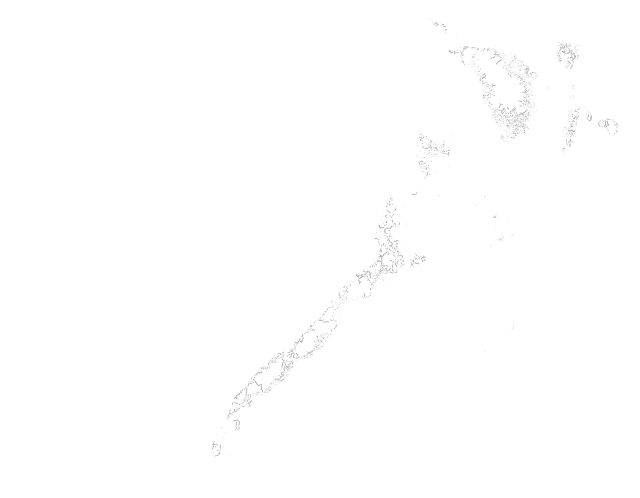

CPU times: user 7.7 s, sys: 270 ms, total: 7.97 s
Wall time: 8.71 s


In [7]:
%%time
fpath = '../datasets/networks/regional_drive_graphs/MIMAROPA Region.pkl' 
g_mim = load_pickle(fpath)

fig, ax = ox.plot_graph(
    g_mim, figsize=(8,8),
    node_size=.25, edge_linewidth=.25,
    bgcolor='none', show=False, close=False,
    node_zorder=2
)

plt.show()
plt.close()

In [ ]:
path = '../datasets/networks/regional_drive_graphs'

# query graph network of Bangsamoro Autonomous Region In Muslim Mindanao (BARMM)
save_osmnx_network(
    unique_regions,
    ix=16,
    gpd_gadm=gpd_gadm,
    dir_savepath=path,
    depth=3
)

At region: Bangsamoro Autonomous Region In Muslim Mindanao (BARMM)
Getting target and adjacent geographies with depth 3
Finding adjacent geographies for PSGC 1900000000 with max_depth=3
Detected administrative level: region
Finding adjacent areas at depth 1...
Found 217 adjacent areas at depth 1
Finding adjacent areas at depth 2...
Found 271 adjacent areas at depth 2
Finding adjacent areas at depth 3...
Found 258 adjacent areas at depth 3
Geography processing completed in 15.74 seconds


In [ ]:
%%time
fpath = '../datasets/networks/regional_drive_graphs/Bangsamoro Autonomous Region In Muslim Mindanao (BARMM).pkl' 
g_mim = load_pickle(fpath)

fig, ax = ox.plot_graph(
    g_mim, figsize=(8,8),
    node_size=.25, edge_linewidth=.25,
    bgcolor='none', show=False, close=False,
    node_zorder=2
)

plt.show()
plt.close()

# 2. Filling in Gaps
* * *
Querying from `osmnx` may not return the graph network of the entire region. This is especially true for Region IV-A (CALABARZON), Region IV-B (or MIMAROPA), and BARMM. In this section, we show the incomplete graph networks that `osmnx` returns, which we will augment after by querying using the `overpass turbo` API.

In [3]:
!ls '../datasets/networks/regional_drive_graphs'

'Bangsamoro Autonomous Region In Muslim Mindanao (BARMM).pkl'
'Cordillera Administrative Region (CAR).pkl'
'MIMAROPA Region.pkl'
'National Capital Region (NCR).pkl'
'Region II (Cagayan Valley).pkl'
'Region III (Central Luzon).pkl'
'Region I (Ilocos Region).pkl'
'Region IV-A (CALABARZON).pkl'
'Region IX (Zamboanga Peninsula).pkl'
'Region V (Bicol Region).pkl'
'Region VII (Central Visayas).pkl'
'Region VIII (Eastern Visayas).pkl'
'Region VI (Western Visayas).pkl'
'Region XI (Davao Region).pkl'
'Region XIII (Caraga).pkl'
'Region XII (SOCCSKSARGEN).pkl'
'Region X (Northern Mindanao).pkl'


## 2.1. Incomplete graphs
The images are output of code that plots the graph network using matplotlib. To minimize the resources to run this section, we'll just display the .JPG of the graphs' plots.

**Notes**:
1. Region IV-A
    * The roads of the islands such as Polillo and Patnanungan Islands are not captured
    * Said islands are located east of Infanta, Quezon or at sea just above the mid-section of the region
3. Region IV-B
    * Only the island of Mindoro is returned using the method we use for querying osmnx
    * MIMAROPA includes Marinduque, Romblon, and Palawan whose road network were not captured
5. BARMM
    * Only the roads in the Cotabato City area are included
    * Sulu and Tawi-tawi, for example, are excluded

<div style="display: flex; justify-content: space-around; align-items: flex-start;">
    <div style="text-align: center; width: 30%;">
        <p style="margin-top: 5px; font-size: 14px; color: #333;">Region IV-A (CALABARZON)</p>
        <img src="../output/github_docs/drive_graph_region4a.jpg" alt="Image 1" style="width: 100%; height: auto;">
    </div>
    <div style="text-align: center; width: 30%;">
        <p style="margin-top: 5px; font-size: 14px; color: #333;">Region IV-B (MIMAROPA)</p>
        <img src="../output/github_docs/drive_graph_region4b.jpg" alt="Image 2" style="width: 100%; height: auto;">
    </div>
    <div style="text-align: center; width: 30%;">
        <p style="margin-top: 5px; font-size: 14px; color: #333;">BARMM</p>
        <img src="../output/github_docs/drive_graph_barmm.jpg" alt="Image 3" style="width: 100%; height: auto;">
    </div>
</div>

## 2.2. Augment

### Helper functions

In [17]:
def geojson_to_osmnx_graph(geojson_file_path):
    """
    Convert GeoJSON from Overpass Turbo to OSMnx graph
    """
    # Load the GeoJSON file
    with open(geojson_file_path, 'r') as f:
        geojson_data = json.load(f)
    
    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])
    
    # Filter only LineString geometries (roads)
    gdf_lines = gdf[gdf.geometry.type == 'LineString'].copy()
    
    if len(gdf_lines) == 0:
        raise ValueError("No LineString geometries found in GeoJSON")
    
    # Create NetworkX graph
    G = nx.MultiDiGraph()
    
    # Extract nodes and edges
    node_id = 0
    node_dict = {}  # To store coordinate -> node_id mapping
    
    for idx, row in gdf_lines.iterrows():
        line = row.geometry
        coords = list(line.coords)
        
        # Add nodes for start and end points
        edge_nodes = []
        for coord in [coords[0], coords[-1]]:  # Start and end points
            coord_key = (round(coord[0], 7), round(coord[1], 7))  # Round for consistency
            
            if coord_key not in node_dict:
                node_dict[coord_key] = node_id
                G.add_node(node_id, x=coord[0], y=coord[1])
                node_id += 1
            
            edge_nodes.append(node_dict[coord_key])
        
        # Add edge
        start_node, end_node = edge_nodes
        
        # Extract edge attributes from GeoJSON properties
        edge_attrs = {
            'geometry': line,
            'length': line.length,
            'osmid': row.get('id', f'way_{idx}'),
        }
        
        # Add other properties from the GeoJSON
        if hasattr(row, 'properties') and row.properties:
            for key, value in row.properties.items():
                if key not in ['geometry']:
                    edge_attrs[key] = value
        
        # Add edge in both directions for undirected roads
        G.add_edge(start_node, end_node, **edge_attrs)
        G.add_edge(end_node, start_node, **edge_attrs)
    
    # Set graph attributes
    G.graph['crs'] = 'EPSG:4326'
    G.graph['name'] = 'Graph from GeoJSON'
    
    return G

In [18]:
def union_osmnx_graphs(G1, G2, tolerance=1e-6):
    """
    Union two OSMnx graphs, merging nearby nodes and combining edges
    
    Parameters:
    - G1, G2: OSMnx graphs to union
    - tolerance: Distance tolerance for merging nearby nodes (in degrees)
    """
    # Create a copy of G1 as the base
    G_union = G1.copy()
    
    # Get the maximum node ID from G1 to avoid conflicts
    max_node_id = max(G1.nodes()) if G1.nodes() else -1
    
    # Create mapping for G2 nodes to avoid ID conflicts and merge nearby nodes
    node_mapping = {}
    
    for node_id, node_data in G2.nodes(data=True):
        node_x, node_y = node_data['x'], node_data['y']
        
        # Check if there's a nearby node in G_union
        merged = False
        for union_node_id, union_node_data in G_union.nodes(data=True):
            union_x, union_y = union_node_data['x'], union_node_data['y']
            
            # Calculate distance
            distance = ((node_x - union_x)**2 + (node_y - union_y)**2)**0.5
            
            if distance < tolerance:
                # Merge with existing node
                node_mapping[node_id] = union_node_id
                merged = True
                break
        
        if not merged:
            # Add as new node with new ID
            max_node_id += 1
            new_node_id = max_node_id
            node_mapping[node_id] = new_node_id
            G_union.add_node(new_node_id, **node_data)
    
    # Add edges from G2 to G_union
    for u, v, key, edge_data in G2.edges(keys=True, data=True):
        new_u = node_mapping[u]
        new_v = node_mapping[v]
        
        # Check if this edge already exists
        if not G_union.has_edge(new_u, new_v, key):
            G_union.add_edge(new_u, new_v, key=key, **edge_data)
    
    return G_union

### Augment per Region
We leave code in the cell block to demonstrate how we filled the incomplete graphs of the aforementioned regions. We only show the code for Region IV-A since the code is the same for Region IV-B and BARMM. Note: the cell block below is commented out since it's purely for demonstration only.

In [ ]:
# # The pickle file shown below is already the complete graph. However, I am leaving this here to demonstrate
# # how we augment our osmnx-queried graph networks using .geojson from Overpass Turbo
# fpath = '../datasets/networks/regional_walk_graphs/Region IV-A (CALABARZON).pkl' 
# g_net = load_pickle(fpath)

# # This is our .geojson exported directly after writing a query to get the roads in Polillo and the other islands
# # that were missing from our osmnx-queried graph network
# g_calabarzon_etal = geojson_to_osmnx_graph('../datasets/calabarzon_polillo_etal.geojson')

# # We convert our .geojson to an osmnx graph object and merge it with our original CALABARZON drive graph network
# g_mrg = union_osmnx_graphs(g_net, g_calabarzon_etal)

# # We overwrite the orignal pickle file of our Region IV-A pickle file
# fpath = '../datasets/networks/regional_drive_graphs/Region IV-A (CALABARZON).pkl'
# save_pickle(fpath, g_mrg)

## 2.3. Completed graphs

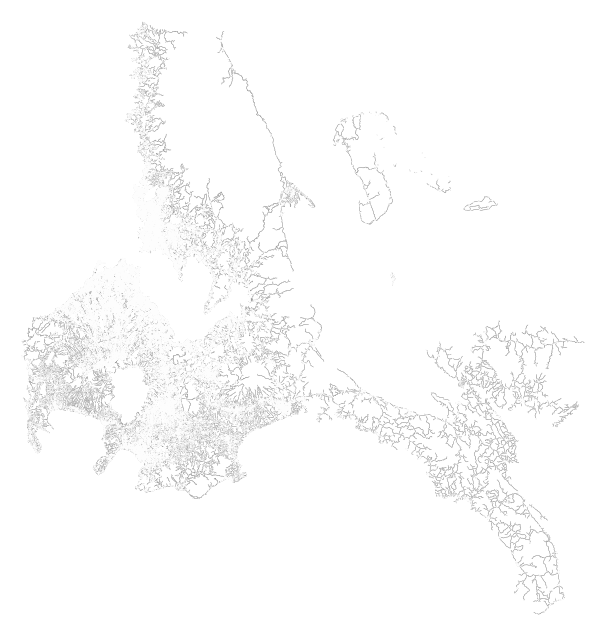

CPU times: user 52.4 s, sys: 765 ms, total: 53.2 s
Wall time: 54.7 s


In [21]:
%%time
fpath = '../datasets/networks/regional_drive_graphs/Region IV-A (CALABARZON).pkl' 
g_4a = load_pickle(fpath)

fig, ax = ox.plot_graph(
    g_4a, figsize=(8,8),
    node_size=.25, edge_linewidth=.25,
    bgcolor='none', show=False, close=False,
    node_zorder=2
)

plt.show()
plt.close()

# 3. Overpass Turbo Queries

## Region IV-A

## Region IV-B

## BARMM